# 05 Publishing Scientific Codes

In [86]:
from math import floor, sqrt
import numpy
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams.update({'font.size': 15})
import pandas as pd

If all goes well, it's likely that at some point you are going to want to publish your code, or at the very least show your code to another person. In this case, it would therefore be great if you could make it as easy as possible to some other person to install and run you code (and potentially even hack away at it themselves). In order to do this, you need to use tools which enable easy installation and replication of your runtime environment.

* At some point, it is likely you're going to want to publish your code or give your code to another person
* You want to make it as easy as possible for the other person to install and run your code
* To do this, need to use tools to enable easy installation, replication of runtime environment, distribution of code

<center>![Automation](https://intellyx.com/wp-content/uploads/2015/11/automate-all-the-things.jpg)</center>

## Automating installation

For simple python codes, installation may be as easy as downloading the code and running `python filename.py`. However, for more complex codes which are spread over many files, require compilation and/or have multiple dependencies, installation can get a lot trickier. For such cases, it therefore becomes necessary to have some way of automating the installation and build process. One such way of doing this is by using Makefiles.

### Make

<center>![Automation](https://imgs.xkcd.com/comics/automation.png )
Automation - [xkcd](https://xkcd.com/1319/)</center>

As projects grow, they often end up spred across many files and directories with complex inter-dependencies. If a change is made to one file, this can have a knock on effect to several other files up the chain of dependencies. Keeping track of all of this and making sure that all files are kept up to date can quickly get complicated and time-consuming.

A solution to this is to automate this using a tool such as `GNU Make`. Make can be used to describe the dependencies between files. When a project is rebuilt, it will look to see which files have changed and only rebuild the bits that need rebuilding. This can save a lot of time for large projects where rebuilding everything from scratch can take a while. 

These dependencies between files and instructions for how to build them are described in a `Makefile`. The syntax of a Makefile is best illustrated with an example. Let's say that we have a LaTeX document (`report.tex`). This includes a figure (`figures/fig.pdf`) which is produced by running a python script (`py/plot.py`) which plots data (`data/data.h5`) generated by a C++ script (`cpp/main.cpp`). It also contains a BibTeX file (`library.bib`) containing the references. In order to compile this all by hand, we'd need to execute:

```bash
g++ cpp/main.cpp -o main     # compile c++ script
./main                       # run c++ executable to generate data/data.h5
cd py
python plot.py               # run python script to generate figures/fig.pdf
cd ..
pdflatex report              # compile LaTeX file
bibtex report                # run BibTeX to generate references
pdflatex report              # recompile LaTeX file to update references
pdflatex report
```

This is not so bad for our small project, however imagine if you had several plots and that the report was spred across multiple LaTeX files. This would require many different commands to build, and it would be quite easy to miss out one or two or execute them in the wrong order. We can therefore make life simpler for ourselves by automating the build process by using a Makefile.

Makefiles are made up of 'rules' which have the following structure:

```make
target: dependency1 dependency2 ....
    action1
    action2
```

Here, `target` is usually the name of the file we wish to build (though could also be the name of an action such as `clean`), `dependencyX` are the names of the files that the file we want to build depends on (so if they change we'll need to rebuild our target file as well). `actionX` are the bash command(s) that need to be executed in order to build our target file (e.g. compilation instructions). We can also define variables in the Makefile. By convention, these are always in upper case. The variable can then be referred to elsewhere in the code as `${VARNAME}` or `$(VARNAME)`.

Let's write a Makefile for our example project to illustrate this better:

#### Makefile
```make
CPP = g++    # Define variable (C++ compiler)

report.pdf: report.tex library.bib figures/fig.pdf
    pdflatex report
    bibtex report
    pdflatex report
    pdflatex report

figures/fig.pdf: py/plot.py data/data.h5
    cd py; python plot.py
    
data/data.h5: cpp/main.cpp
    ${CPP} cpp/main.cpp -o main    # Uses variable defined above for compiler command
    ./main
```

This may on the face of it look more complicated than the sequence of bash commands we needed to build our project before, but once we've written the Makefile, for each rebuild we just need to execute the command 

    $ make 
    
(assuming the structure of our project does not change). Make will then check to see which of the dependencies have changed and rebuild as necessary. For instance, if the LaTeX file has changed but the python and C++ scripts have not, the python and C++ scripts will not be executed to generate new data and a new figure. 

We can also use make to build specific parts of our project by executing it with a target as an argument. For example, if we just wish to generate the data and don't care about updating the figure or report, then you can execute 

    $ make data/data.h5
    
If you do not give make an argument, it will default to the first target defined in the Makefile - in this case, `report.pdf`.

One thing to note here: if you need to change directories to execute a command, then `cd` must be on the same line as that command (as can be seen here for the build instructions for `figures/fig.py`). This is because each action is executed in its own sub-shell: any changes to the shell environment (such as changing directory) will therefore be restricted to that line only. The shell environment will then revert back to its original state for the next action. 

### Read more

- [A minimal make tutorial](http://kbroman.org/minimal_make/)
- A more detailed [make tutorial](http://opensourceforu.com/2012/06/gnu-make-in-detail-for-beginners/)
- The full [make manual](https://www.gnu.org/software/make/manual/make.html)

## Replicating runtime environments

Unfortunately for those of us developing code, no two runtime environments are exactly the same. Every computational setup has its own unique hardware and selection of installed software. However, we wish our code to be as reproducible as possible: ideally, it should be possible to gain exactly the same results, regardless of what system the code is run on. In the interests of open research, it's often the case that we also would like to make our code as accessible as possible. We'd therefore like to support a range of operating systems and computer hardware. 

Whilst it is impossible to replicate exactly the runtime environment in which you developed your code on another machine (no two sets of hardware are identical), it is possible to get a close approximation of the software. 

### Conda
- `conda` is a package and environment management system which allows users to create multiple runtime environments (e.g. containing different versions of libraries) and easily switch between them
- Allows users of your code to install exact version of libraries you use without them having to wreck their own setup

Conda package building tutorials are [here](https://docs.continuum.io/docs_oss/conda/build_tutorials).

### Containers
* Not only does this make it much easier and faster for someone else to run your code, it also means that their 'experimental setup' is the same as yours, e.g. they're running the same versions of libraries. It means they can also run code on their system regardless of their operating system: as long as they have Docker installed, they could run your Linux code on a Mac or even a Windows machine

Containers a way of producing a lightweight, standalone, executable package of a piece of software. This package (or *container image*) includes everything required to run the software: the code itself, the runtime environment, libraries, settings etc. Software run inside the container will be isolated from the rest of the system. Many containers can be run on the same machine at once, allowing multiple versions of a code or runtime environment to exist at once and run at the same time without conflict. 

Containers share many similarities with virtual machines in that both allow code to be run in isolated runtime environments. However, container images are much more lightweight (typically tens of MBs) as they share the OS kernel with other containers; by contrast, virtual machines include a full copy of an operating system, so typically take up tens of GBs. Container images contain exactly what is required by the software and no more; virtual machines contain a of lot of extra material that is likely to already exist on the host machine (e.g. a full operating system).

<div style="float:left;width:49%">
     <img src="Container@2x.png" alt="Containers">
     
     <center>Containers</center>
</div>
<div style="float:right;width:49%">
    <img src="VM@2x.png" alt="Virtual machines">
    
    <center>Virtual machines</center>
</div>

<center>Source: [Docker](https://www.docker.com/what-container)</center>

### Docker

Docker is the most popular service for containers. The docker platform can be installed and run on Linux, Mac OS and Windows, allowing images created on one OS to be run on any other. Let's demonstrate how docker images work by building one for the following python application:

#### example_app.py
```python
import socket
import silly
import time

def hello(s):
    print("Hello {}!".format(s))
    print(silly.sentence())

if __name__ == "__main__":
    name = socket.gethostname() # get system hostname
    while(True):
        hello(name)
        time.sleep(2)
```

Docker images are described by a `Dockerfile`. This defines the environment inside the container and tells the container how to communicate with your system outside of the container. Let's create a `Dockerfile` for our python script:

#### Dockerfile

```C
# Use an official Python runtime as a base image
FROM python:3.5-slim

# Set the working directory to /src
WORKDIR /src

# Copy the current directory contents into the container at /src
ADD . /src

# Install any needed packages specified in requirements.txt
RUN pip install -r requirements.txt

# Make port 80 available to the world outside this container
EXPOSE 80

# Run app.py when the container launches
CMD ["python", "example_app.py"]
```

Note that the `Dockerfile` refers to the file `requirements.txt`. This contains a list of the python libraries required by the script, so in our case will look like:

#### requirements.txt
```txt
silly
```

We need to place these three files all in the same folder. The Docker image can then be created by executing 

    docker build -t example_image .
    
This will build the image in your machine's local Docker image registry, as you should see by executing
    
    $ docker images
    
    REPOSITORY          TAG                 IMAGE ID            
    example_image       latest              505747e4b069        
    
We can run our python code within a container by executing 
    
    docker run example_image
    
Our code has a never-ending while loop, so instead of causing our terminal to hang indefinitely, we can instead run our code in *detached mode* by executing

    docker run -d example_image
    
We can see its status by running

    $ docker ps
    
    CONTAINER ID        IMAGE               COMMAND                  CREATED             
    a730c158ffca        example_image       "python example_ap..."   5 seconds ago       

The code in this container can then be stopped by executing `docker stop` followed by the `CONTAINER ID`: 

    docker stop a730c158ffca

### Sharing images

We can now upload this image and run it on another machine. First, you need to sign into your [cloud.docker.com](https://cloud.docker.com/) account:
    
    docker login
        
We then need to publish the image:

    docker tag example_image username/repository_name:tag_name
    
Here, `username` is your docker cloud username and `repository_name` is the name of an exisiting repository in your docker cloud account you'd like to upload the image to. `:tag_name` acts as a sort of version label. If you don't specify it, docker will assume the tag `:latest`. We then upload this tagged image:

    docker push username/repository_name:tag_name
    
Our image is now publicly available and can be run by executing

    docker run username/repository_name:tag_name
    
You can try this now with the example code above (which is also in the `docker_example` folder of this repo) - try executing

    docker run harpolea/scientific_programming:latest

## Distributing code
* Can be as simple as sharing a link to your github repo 
* For python, can upload code to the Python Package Index, `pypi`, which will allow anyone else to install code using `pip`
* If packaged code in a Docker image, can add to `Docker Hub`, a cloud-based registry service which will allow others to easily find your code
* Make sure your code has some kind of software license (e.g. BSD, MIT, GPL) - see http://choosealicense.com/
* Give your code a DOI - e.g. using `zenodo`

If you've written a bit of scientific code that does something cool, you probably will want to share it with someone else. This can be as simple as sharing a link to your github repo via email / twitter / your blog, however there are also various package indexes you can upload your code to, making it easier for others to find and download. 

For python, packages can be uploaded to the [Python Package Index](https://pypi.python.org/pypi), PyPI. This will allow anyone to download and install your code by running `pip install package_name`. For python and general code projects, conda packages can be uploaded to [anaconda.org](Anaconda.org), allowing anyone to download and install the code (and conda environment if specified) by running `conda install -c CHANNEL package_name`, where `CHANNEL` is your [anaconda.org](Anaconda.org) username.

## Presenting results

* Something here about how to make nice looking and informative plots? There are far too many terrible figures that look boring and are impossible to understand out there.
* If you want to convince someone that your code is producing results that are 1) correct and 2) interesting, it's important to present them in a way that is 
    - easy to understand - the point of figures is to present data in a way that is easier to understand than simply looking at the raw data. If your figure is hard to read, readers will simply skip over it.
    - informative - the way data is presented can powerfully influence how your reader will interpret the results
    - attractive - if someone is just skimming a paper, you want to make sure that your figures catch their eye!
* It's very tempting to just use the default settings to produce your plots, but in almost all cases figures could be seriously improved by a few tweaks (e.g. adding a legend, increasing font size of axis labels, changing the default colours)
* See [this article](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833) for some key points to consider when making figures
* Interactive plots can be a much more powerful way to present data than traditional static plots - some journals are moving to allow these sorts of plots in (the online versions of) papers (and this is only going to increase in the future). Libraries such as bokeh and plotly allow easy generation of such plots.
* Beyond matplotlib: [bokeh](http://bokeh.pydata.org), [seaborn](http://seaborn.pydata.org/index.html), [plotly](https://plot.ly/), [vispy](http://vispy.org)
    - matplotlib is extremely powerful, but it takes a lot of work to make good plots. 
    - Make your life easier by using a package with better default settings

The way that data is presented has a huge impact on how it is interpreted by the reader. Let's use some [data](https://opendata.socrata.com/Business/All-Starbucks-Locations-in-the-World/xy4y-c4mk) about Starbucks per country. The following plots compare the number of Starbucks per country (for those countries containing >= 200 stores). In the first plot, the area of the bubbles is proportional to the number of stores in the country; in the second, the number of stores is instead proportional to the radius. 

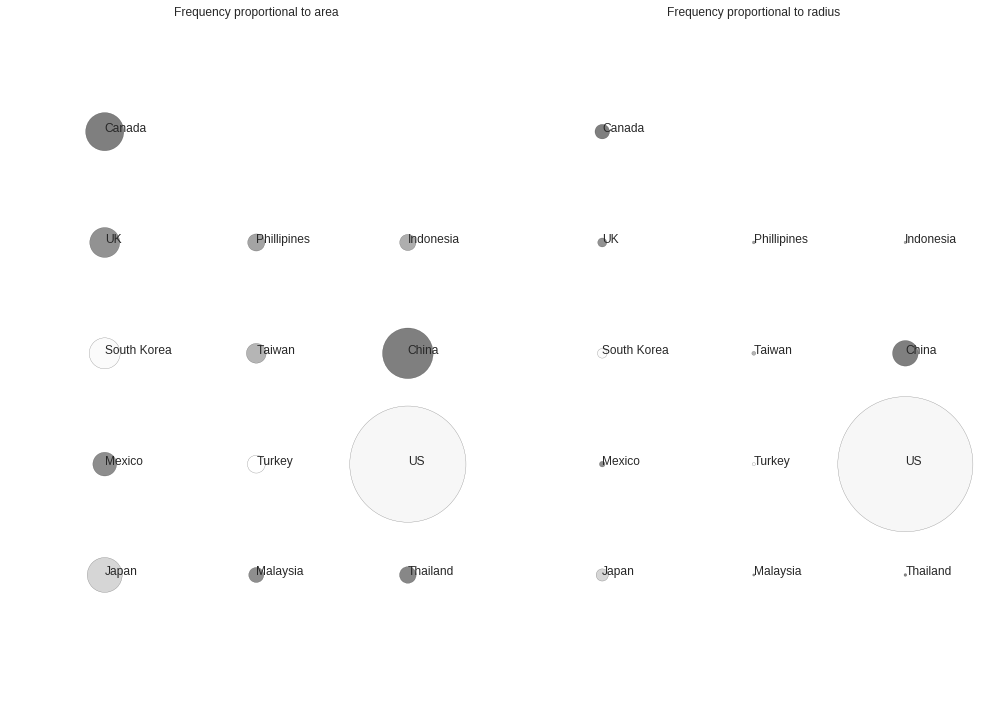

In [90]:
df = pd.read_csv('starbucks.csv', sep=',')
dat = df.values

countries = {}

for c in dat:
    countries.setdefault(c[0], 0)
    countries[c[0]] += 1

names = []; freq = []
name_dict = {'CA': 'Canada', 'GB': 'UK', 'PH': 'Phillipines', 'ID': 'Indonesia', 'KR': 'South Korea', 'TW': 'Taiwan', 'CN': 'China', 'MX': 'Mexico', 'TR': 'Turkey', 'US': 'US', 'JP': 'Japan', 'MY': 'Malaysia', 'TH': 'Thailand'}

for key, value in countries.items():
    if value >= 200:
        names.append(name_dict[key])
        freq.append(value)
    
# switch to lists for plotting
#names = list(countries.keys())
#freq = list(countries.values())

# generate positions of points 
xs = [i % floor(sqrt(len(names))) for i in range(len(names))] 
ys =  [int(i / floor(sqrt(len(names)))) for i in range(len(names))]
colours = numpy.random.rand(len(names))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,10))
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
axes[0].scatter(xs, ys, s=freq, c=colours, alpha=0.5)
for i, name in enumerate(names):
    axes[0].annotate(name, (xs[i], ys[i]))
axes[0].axis('off')
axes[0].set_title('Frequency proportional to area')
axes[1].scatter(xs, ys, s=numpy.array(freq)**2*1e-4, c=colours, alpha=0.5)
for i, name in enumerate(names):
    axes[1].annotate(name, (xs[i], ys[i]))
axes[1].axis('off')
axes[1].set_title('Frequency proportional to radius')
plt.tight_layout()
plt.show()

In the second plot, the number of stores in the US appears to completely dwarf the number of stores in all other countries, however if we look at the data, we see that there are only around 5 times as many stores there than in China, and 9 times as many stores as in Canada. The way the data has been plotted has therefore distorted our interpretation.

In [83]:
print('Number of stores in the US / China: {}'.format(countries['US']/ countries['CN']))
print('Number of stores in the US / Canada: {}'.format(countries['US']/ countries['CA']))

Number of stores in the US / China: 5.275283092541976
Number of stores in the US / Canada: 9.278846153846153


<center>![Defaults vs tweaked](journal.pcbi.1003833.g004.png)
These two plots of the sine and cosine functions demonstrate the importance of going beyond the defaults - the one of the left uses the matplotlib default settings, the one of the right has been tweaked so that it is much more informative. [source](http://dx.doi.org/10.1371/journal.pcbi.1003833.g004)</center>

# TODO: USE A MORE INTERESTING DATASET TO REALLY SHOW MATPLOTLIB'S CRAPNESS?

In [87]:
xs = numpy.linspace(-numpy.pi, numpy.pi)
ys = [numpy.sin(xs), numpy.cos(xs)]

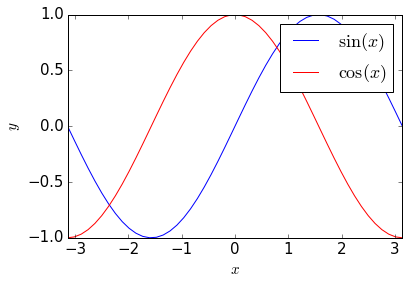

In [88]:
plt.plot(xs, ys[0], 'b', label=r'$\sin(x)$')
plt.plot(xs, ys[1], 'r', label=r'$\cos(x)$')
plt.xlim(xs[0], xs[-1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

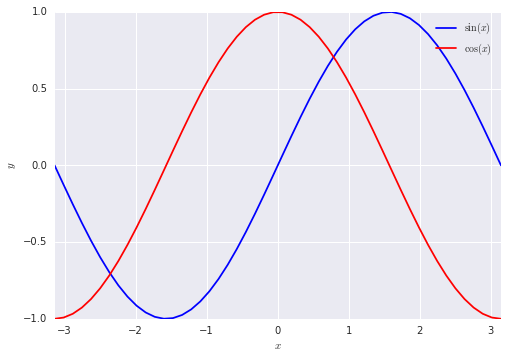

In [89]:
import seaborn 

plt.plot(xs, ys[0], 'b', label=r'$\sin(x)$')
plt.plot(xs, ys[1], 'r', label=r'$\cos(x)$')
plt.xlim(xs[0], xs[-1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

In [4]:
import bokeh.plotting as bkh
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [5]:
fig = bkh.figure()
fig.line(xs, ys[0], legend='sin(x)', line_color='blue')
fig.line(xs, ys[1], legend='cos(x)', line_color='red')
fig.xaxis.axis_label = 'x'
fig.yaxis.axis_label = 'y'
bkh.show(fig)

## Read more
- [What is a container?](https://www.docker.com/what-container)
- [Getting started with Docker](https://docs.docker.com/get-started/)